# 🤖 Prototyping models for Meet Fresh recommender - Content-based Filtering using Custom Meet Fresh Embedding
For Meet Fresh product solution POC, we prototype multiple models that could be used for providing recommendations on different levels -

- Recommending ingredients based on customer ingredient ratings
- Recommending products based on ingredient selections

Here we outline a POC for recommending ingredients by content-based filtering that utilizes customer-ingredient rating matrix and custom trained Meet Fresh ingredient embedding as item features.

References:
- [Creating Word Embeddings: Coding the Word2Vec Algorithm in Python using Deep Learning](https://towardsdatascience.com/creating-word-embeddings-coding-the-word2vec-algorithm-in-python-using-deep-learning-b337d0ba17a8)
- [Content Based Filtering by hand](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/recommendation_systems/solutions/content_based_by_hand.ipynb)

### Model 2: Content-Based Filtering with Custom Meet Fresh Embedding
This content-based model uses customer-ingredient rating matrix as well as a set of custom trained meet fresh ingredient embedding as feature space, outputs predicted ratings for the ingredients that have not been rated on by the customer.

Based on predicted ratings for unrated ingredients, recommendations are provided by sorting on predicted ratings.

This approach helps addressing cold start problem from Collaborative Filtering prototyped previously. While there is limited ratings data from other customers, we utilize this approach in providing ingredient-level recommendations to customers. 

#### I - Training Custom Ingredient Embedding
But first we need to train custom embedding using a Word2Vec (CBOW) shallow neural network on Meet Fresh ingredient text descriptions

In [ ]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

from scipy import sparse
from sklearn.decomposition import PCA

import nltk
nltk.download('stopwords')
nltk.download('punkt')

%matplotlib inline

2023-07-03 12:47:47.183318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 12:47:52.455504: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-03 12:48:03.916780: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-07-03 12:48:03.917211: W tensorflow/strea

In [ ]:
sw = stopwords.words('english')

In [ ]:
%%bigquery ingredient_df
SELECT * FROM `dsxl-ai-advanced-program.meetfresh.dim_ingredient`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# this is our training corpus
lines = list(ingredient_df['ingredient_long_description'])
lines

['By careful selection of the finest soft and most fragrant taro following traditional techniques, the texture of each taro ball is soft, chewy, and delicate.',
 'Miniature version of our signature Taro Balls',
 'The texture of the finest carefully selected taro is dense and soft and has appetizing and constipation prevention effects.',
 'Finely selected taro in sweet paste-like texture',
 'Bouncy, chewy, and nutty black sesame rice balls',
 'Caramel-flavored pudding with a silky smooth texture',
 'Almond-flavored pudding with a silky smooth texture',
 'Creamy, vanilla ice cream',
 'Smooth and stretchy glutinous rice cake with an added chewy texture',
 'Soft and chewy combination of both sweet potato and taro',
 'Releases a fragrant smell through the air after cooking, it has abundant iron which promotes circulation and increased immunity.',
 'Soft peanuts for the perfect amount of crunch in each bite',
 'Dried herbal grass delivered directly from its place of origin, has a cooling eff

In [ ]:
# preprocess text data
# remove new lines
lines = [line.rstrip('\n') for line in lines]

# make all characters lower
lines = [line.lower() for line in lines]

# remove punctuations from each line
lines = [line.translate(str.maketrans('', '', string.punctuation)) for line in lines]

# tokenize
lines = [word_tokenize(line) for line in lines]

def remove_stopwords(lines, sw = sw):
    '''
    The purpose of this function is to remove stopwords from a given array of 
    lines.
    
    params:
        lines (Array / List) : The list of lines you want to remove the stopwords from
        sw (Set) : The set of stopwords you want to remove
        
    example:
        lines = remove_stopwords(lines = lines, sw = sw)
    '''
    
    res = []
    for line in lines:
        original = line
        line = [w for w in line if w not in sw]
        line = [w for w in line if w.isalpha()]
        if len(line) < 1:
            line = original
        res.append(line)
    return res
    
cleaned_lines = remove_stopwords(lines = lines, sw = sw)

In [ ]:
cleaned_lines

[['careful',
  'selection',
  'finest',
  'soft',
  'fragrant',
  'taro',
  'following',
  'traditional',
  'techniques',
  'texture',
  'taro',
  'ball',
  'soft',
  'chewy',
  'delicate'],
 ['miniature', 'version', 'signature', 'taro', 'balls'],
 ['texture',
  'finest',
  'carefully',
  'selected',
  'taro',
  'dense',
  'soft',
  'appetizing',
  'constipation',
  'prevention',
  'effects'],
 ['finely', 'selected', 'taro', 'sweet', 'pastelike', 'texture'],
 ['bouncy', 'chewy', 'nutty', 'black', 'sesame', 'rice', 'balls'],
 ['caramelflavored', 'pudding', 'silky', 'smooth', 'texture'],
 ['almondflavored', 'pudding', 'silky', 'smooth', 'texture'],
 ['creamy', 'vanilla', 'ice', 'cream'],
 ['smooth',
  'stretchy',
  'glutinous',
  'rice',
  'cake',
  'added',
  'chewy',
  'texture'],
 ['soft', 'chewy', 'combination', 'sweet', 'potato', 'taro'],
 ['releases',
  'fragrant',
  'smell',
  'air',
  'cooking',
  'abundant',
  'iron',
  'promotes',
  'circulation',
  'increased',
  'immunity'],


#### Step 2: Sliding Window of Words
Slide a window of words across each token list. For each window extract a center word and the context words depending on a context half-size.

In [ ]:
def get_windows(words, C):
    '''
    This function extracts pairs of context words and center word that make up the training set for CBOW model.
    
    params:
        The first argument of this function is a list of words (or tokens).
        The second argument, `C`, is the context half-size.
        Context words are made of `C` words to the left and `C` words to the right of the center word.
    '''
    i = C
    while i < len(words) - C:
        center_word = words[i]
        context_words = words[(i - C):i] + words[(i+1):(i+C+1)]
        yield context_words, center_word
        i += 1

In [ ]:
context_list = []
center_list = []
for token_list in cleaned_lines:
    for x, y in get_windows(
                token_list,
                2
            ):
        context_list.append(x)
        center_list.append(y)
        print(f'{x}\t{y}') 

['careful', 'selection', 'soft', 'fragrant']	finest
['selection', 'finest', 'fragrant', 'taro']	soft
['finest', 'soft', 'taro', 'following']	fragrant
['soft', 'fragrant', 'following', 'traditional']	taro
['fragrant', 'taro', 'traditional', 'techniques']	following
['taro', 'following', 'techniques', 'texture']	traditional
['following', 'traditional', 'texture', 'taro']	techniques
['traditional', 'techniques', 'taro', 'ball']	texture
['techniques', 'texture', 'ball', 'soft']	taro
['texture', 'taro', 'soft', 'chewy']	ball
['taro', 'ball', 'chewy', 'delicate']	soft
['miniature', 'version', 'taro', 'balls']	signature
['texture', 'finest', 'selected', 'taro']	carefully
['finest', 'carefully', 'taro', 'dense']	selected
['carefully', 'selected', 'dense', 'soft']	taro
['selected', 'taro', 'soft', 'appetizing']	dense
['taro', 'dense', 'appetizing', 'constipation']	soft
['dense', 'soft', 'constipation', 'prevention']	appetizing
['soft', 'appetizing', 'prevention', 'effects']	constipation
['finely

#### Step 3: Transform Words into Vectors for Training Set
To create one-hot word vectors, we need to map each unique word to a unique integer (or index). Use helper function, `get_dict`, that creates a Python dictionary that maps words to integers and back.

In [ ]:
# define helper function
def get_dict(line_list):
    """
    Input:
        data: list of text strings that make up of the corpus
    Output:
        word2Ind: returns dictionary mapping the word to its index
        Ind2Word: returns dictionary mapping the index to its word
    """
    data = [element for nested in line_list for element in nested]
    words = sorted(list(set(data)))
    n = len(words)
    idx = 0
    # return these correctly
    word2Ind = {}
    Ind2word = {}
    for k in words:
        word2Ind[k] = idx
        Ind2word[idx] = k
        idx += 1
    return word2Ind, Ind2word

In [ ]:
word2Ind, Ind2word = get_dict(cleaned_lines)
V = len(word2Ind)  # vocabulary size
V

125

In [ ]:
# function to get one-hot vectors for words
def word_to_one_hot_vector(word, word2Ind, V):
    one_hot_vector = np.zeros(V)
    one_hot_vector[word2Ind[word]] = 1
    
    return one_hot_vector

In [ ]:
word_to_one_hot_vector('taro', word2Ind, V)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [ ]:
# create context words vectors as average of one-hot vectors of individual context words
def context_words_to_vector(context_words, word2Ind, V):
    context_words_vectors = [word_to_one_hot_vector(w, word2Ind, V) for w in context_words]
    context_words_vectors = np.mean(context_words_vectors, axis=0)
    
    return context_words_vectors

Pack all the functions above together into one function outputting training examples for model.

In [ ]:
def get_training_example(cleaned_lines, C, word2Ind, V):
    """
    Input:
        cleaned_lines: nested list of cleaned text token lists from text pre-processing
        C: context half-size parameter
        word2Ind: dictionary mapping word to its index in vocabulary
        V: vocabulary size
    Output:
        context word vector
        ceneter word vector
    """
    context_list = []
    center_list = []
    for token_list in cleaned_lines:
        for x, y in get_windows(
                    token_list,
                    C
                ):
            context_list.append(x)
            center_list.append(y)
            
    X = []
    y = []
    for i in range(len(context_list)):
        context_words = context_list[i]
        context_vector = context_words_to_vector(context_words, word2Ind, V)
        X.append(context_vector)
    
    for i in range(len(center_list)):
        center_word = center_list[i]
        center_vector = word_to_one_hot_vector(center_word, word2Ind, V)
        y.append(center_vector)
        
    return X, y

In [ ]:
X, y = get_training_example(cleaned_lines, 2, word2Ind, V)

#### Step 4: Train CBOW Model for Embedding

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
# define embedding size N
N = 20

# define model
cbow_model = Sequential(
    [
        Dense(units = N, activation = 'relu'),
        Dense(units = y.shape[1], activation = 'linear')]
)
  
cbow_model.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   optimizer = tf.keras.optimizers.Adam(0.001))

2023-07-03 13:04:40.131384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-07-03 13:04:40.148132: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-03 13:04:40.148336: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e26eea229bb4): /proc/driver/nvidia/version does not exist
2023-07-03 13:04:40.158207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

In [ ]:
cbow_model.fit(X, y, batch_size=256, epochs=2000, verbose=0)

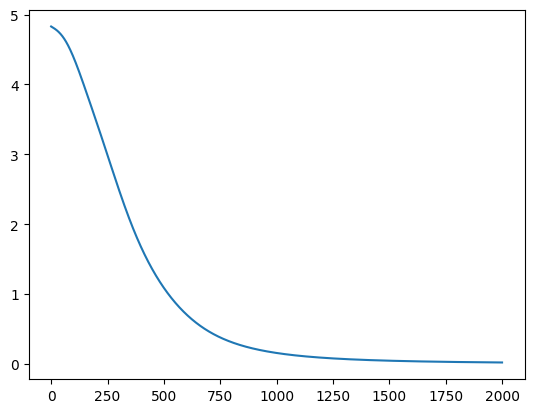

In [ ]:
plt.plot(cbow_model.history.epoch,cbow_model.history.history['loss'])

In [ ]:
# extract the weights from trained neural network model
# these weights are the word embeddings for Meet Fresh ingredients
# either or both w weights could be used as embedding, we use w1 from first layer

w1 = cbow_model.get_weights()[0]

# embedding dictionary with word as key and embedding vector as value
embedding_dict = {}
for word in word2Ind.keys(): 
    embedding_dict[word] = w1[word2Ind.get(word)]

In [ ]:
# visualize the embeddings by convering embeddings into 2D with PCA

embedding_X = np.array(list(embedding_dict.values()))
# dimentionality reduction using PCA
pca = PCA(n_components=2)
# running the transformations
result = pca.fit_transform(embedding_X)
# getting the corresponding words
words = list(embedding_dict.keys())

In [ ]:
# creating a dataframe from the results
df = pd.DataFrame(result, columns=list('XY'))
# adding a columns for the corresponding words
df['Words'] = words
# converting the lower case text to title case
df['Words'] = df['Words'].str.title()

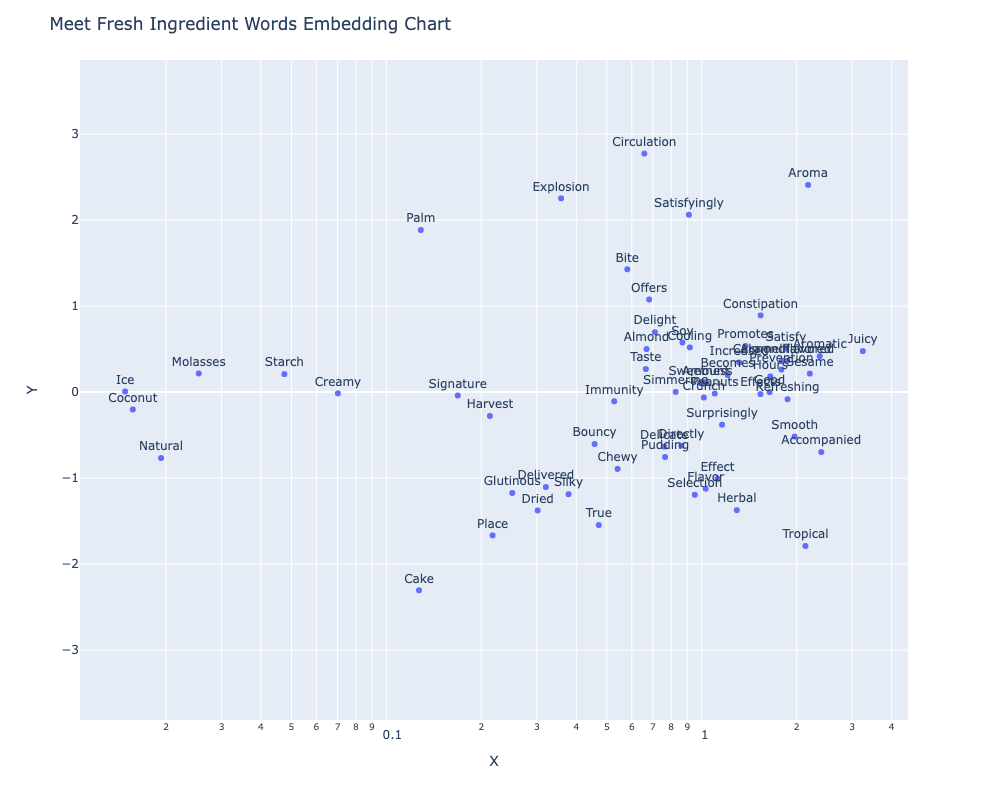

In [ ]:
import plotly.express as px

# plotting a scatter plot
fig = px.scatter(df, x="X", y="Y", text="Words", log_x=True, size_max=60)
# adjusting the text position
fig.update_traces(textposition='top center')
# setting up the height and title
fig.update_layout(
    height=800,
    title_text='Meet Fresh Ingredient Words Embedding Chart'
)
# displaying the figure
fig.show()

In [ ]:
# save the embedding
import pickle 

# with open('saved_ingredient_embedding_dictionary.pkl', 'wb') as f:
#     pickle.dump(embedding_dict, f)
        
with open('saved_ingredient_embedding_dictionary.pkl', 'rb') as f:
    embedding_dict = pickle.load(f)

### II - Content-Based Filtering using Trained Embedding as Features
Now that we have the custom trained word embeddings for Meet Fresh ingredients, we create a vector representation for each ingredient using its text description and use the vector as feature vector for the item.

Content-based filtering model uses the feature space defined by the feature vectors to predict ratings from each customer for each ingredient.

#### Step 1: Create ingredient embeddings

In [ ]:
embedding_dict['taro']

array([ 0.15991925, -0.35228106, -0.6895221 , -0.6528382 ,  1.2570035 ,
        1.2760234 , -1.508231  ,  0.7115914 ,  0.6295069 ,  0.3594366 ,
       -0.7920568 ,  0.8343176 , -0.7932548 ,  0.8127102 ,  1.2525693 ,
        0.63460433,  1.0949285 , -1.0136517 ,  0.9496606 ,  0.20419765],
      dtype=float32)

In [ ]:
# create embeddings for each Meet Fresh ingredient
ingredient_embedding = []
for line in cleaned_lines:
    word_array = np.empty(N)
    for word in line:
        word_array = np.add(word_array, embedding_dict[word])
    ingredient_array = word_array/len(line)
    
    ingredient_embedding.append(ingredient_array)

In [ ]:
# create a dictionary with ingredient_id and its ingredient embedding array
ingredient_embed_dict = dict(zip(ingredient_df['ingredient_name'], ingredient_embedding))

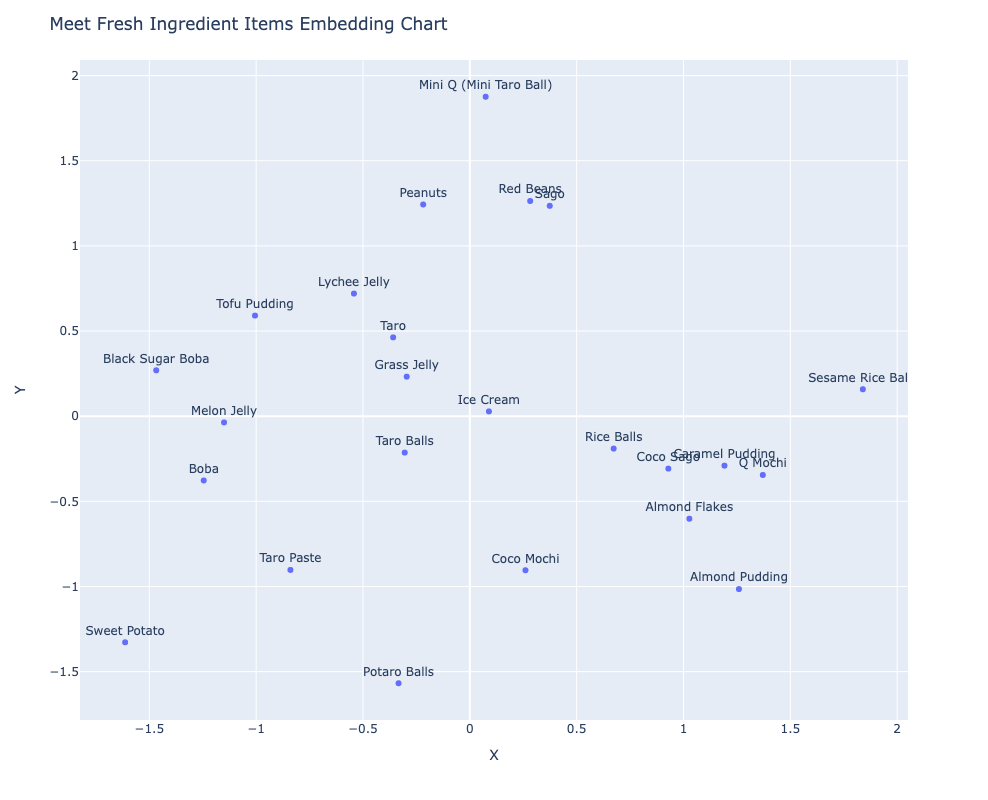

In [ ]:
# visualize ingredients using embeddings and PCA on 2D

ing_embedding_X = np.array(list(ingredient_embed_dict.values()))
# dimentionality reduction using PCA
pca = PCA(n_components=2)
# running the transformations
result = pca.fit_transform(ing_embedding_X)
# getting the corresponding ingredient names
words = list(ingredient_embed_dict.keys())

# creating a dataframe from the results
df = pd.DataFrame(result, columns=list('XY'))
# adding a columns for the corresponding words
df['Ingredients'] = words
# converting the lower case text to title case
df['Ingredients'] = df['Ingredients'].str.title()

# plotting a scatter plot
fig = px.scatter(df, x="X", y="Y", text="Ingredients", log_x=False, size_max=60)
# adjusting the text position
fig.update_traces(textposition='top center')
# setting up the height and title
fig.update_layout(
    height=800,
    title_text='Meet Fresh Ingredient Items Embedding Chart'
)
# displaying the figure
fig.show()

#### Step 2: Compute customer feature matrix
For each customer, we have 1-3 ratings for rated ingredients. Given the ingredient embedding for each ingredient, we compute where each customer lies in the feature space defined by embedding, so that we could create recommendations for ingredients based on similarity measures between customer and ingredient feature vectors.

In [ ]:
%%bigquery ratings_orig_df
SELECT * FROM `dsxl-ai-advanced-program.meetfresh.ft_customer_ingredient_ratings`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
ratings_orig_df['customer_id'] = ratings_orig_df['customer_id'].astype(int)
ratings_orig_df['meetfresh_rating'] = ratings_orig_df['meetfresh_rating'].astype(float)
ratings_orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500029 entries, 0 to 500028
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   customer_id       500029 non-null  int64  
 1   ingredient_id     500029 non-null  object 
 2   ingredient_name   500029 non-null  object 
 3   meetfresh_rating  500029 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 15.3+ MB


In [ ]:
# define some parameters
num_users = len(ratings_orig_df['customer_id'].unique())
num_ingredients = len(ratings_orig_df['ingredient_id'].unique())
num_feats = np.array(ingredient_embedding).shape[1]
num_recommendations = 5

In [ ]:
ingredient_id_dict = dict(zip(ingredient_df['ingredient_id'], ingredient_embedding))
ingredient_dict = {key: ingredient_id_dict[key] for key in ratings_orig_df['ingredient_id'].unique()}

ingredient_name_dict = dict(zip(ingredient_df['ingredient_name'], ingredient_embedding))
ingredient_name_dict = {key: ingredient_name_dict[key] for key in ratings_orig_df['ingredient_name'].unique()}

In [ ]:
# create matrices for customer-ingredient ratings (customer_ingredients)
# and ingredient embedding features (ingredient_feats)

df = ratings_orig_df[['customer_id','ingredient_id','meetfresh_rating']]
customer_ingredients_df = df.pivot_table(values='meetfresh_rating', index=['customer_id'],
                                         columns='ingredient_id', aggfunc='mean', fill_value=0)
ingredient_feats_df = pd.DataFrame.from_dict(ingredient_dict, orient='index')

# turn them into tensorflow objects
customer_ingredients = tf.constant(customer_ingredients_df, dtype = tf.float64)
ingredient_feats = tf.constant(ingredient_feats_df, dtype = tf.float64)
print(f'customer_ingredients type is: {type(customer_ingredients)}', '\n',
      f'ingredient_feats type is: {type(ingredient_feats)}')

customer_ingredients type is: <class 'tensorflow.python.framework.ops.EagerTensor'> 
 ingredient_feats type is: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
# next compute customer feature matrix using the two matrices defined above
# for each customer feature vector, normalize it to sum to 1
users_feats = tf.matmul(customer_ingredients, ingredient_feats)
users_feats = users_feats / tf.reduce_sum(users_feats, axis=1, keepdims=True)
users_feats

<tf.Tensor: shape=(155594, 20), dtype=float64, numpy=
array([[ 0.19157845,  0.13355521,  0.0515675 , ...,  0.06936497,
         0.10179576,  0.11069742],
       [ 0.20189644,  0.13719917,  0.06226509, ...,  0.04279025,
         0.12042201,  0.0996008 ],
       [ 0.12214676,  0.10903437, -0.0204186 , ...,  0.24819126,
        -0.02354382,  0.18536872],
       ...,
       [ 0.26605223,  0.15985674,  0.12878119, ..., -0.12244757,
         0.23623741,  0.03060354],
       [-0.05668348,  0.06589641,  0.01149882, ...,  0.07839543,
        -0.01234555,  0.07853536],
       [ 0.08293656,  0.00124234,  0.07462839, ..., -0.07067721,
         0.04725368,  0.0355153 ]])>

#### Step 3: Determine ingredient recommendations
Now we use user_feats tensor computed above to determine movie ratings and recommendations for customers.

To compute the projected ratings for each ingredient, we compute the similarity measure between the customer's feature vector and the corresponding ingredient feature vector. We use the dot product as our similarity measure. In essence, this is a weighted average rating for each customer

In [ ]:
predicted_ratings = tf.matmul(users_feats, tf.transpose(ingredient_feats))
predicted_ratings

<tf.Tensor: shape=(155594, 22), dtype=float64, numpy=
array([[ 0.19971243,  0.27220238,  0.80391332, ...,  0.18404335,
        -0.3634402 , -0.04446207],
       [ 0.16868542,  0.17951091,  0.67691383, ...,  0.15253601,
        -0.39069014, -0.03173766],
       [ 0.40849901,  0.89594079,  1.65851682, ...,  0.39606219,
        -0.18007017, -0.13008703],
       ...,
       [-0.02423609, -0.39683149, -0.11275092, ..., -0.04337215,
        -0.56012643,  0.04738091],
       [ 0.11257758,  0.34900497,  0.60276083, ...,  0.21354277,
        -0.26856205,  0.2178404 ],
       [-0.15070836,  0.04843425,  0.02654409, ...,  0.06600078,
        -0.04000029,  0.29530651]])>

In [ ]:
# since we do not want to recommend ingredients already rated, mask the rated ingredients for each customer
customer_unrated_ingredients = tf.equal(customer_ingredients, tf.zeros_like(customer_ingredients))
ignore_matrix = tf.zeros_like(tf.cast(customer_ingredients, tf.float64))

predicted_ratings_new = tf.where(
    customer_unrated_ingredients,
    predicted_ratings,
    ignore_matrix)

predicted_ratings_new

<tf.Tensor: shape=(155594, 22), dtype=float64, numpy=
array([[ 0.19971243,  0.27220238,  0.        , ...,  0.18404335,
        -0.3634402 , -0.04446207],
       [ 0.16868542,  0.17951091,  0.        , ...,  0.15253601,
        -0.39069014, -0.03173766],
       [ 0.40849901,  0.89594079,  0.        , ...,  0.39606219,
        -0.18007017, -0.13008703],
       ...,
       [-0.02423609, -0.39683149, -0.11275092, ..., -0.04337215,
        -0.56012643,  0.04738091],
       [ 0.11257758,  0.34900497,  0.        , ...,  0.21354277,
        -0.26856205,  0.2178404 ],
       [-0.15070836,  0.04843425,  0.02654409, ...,  0.06600078,
        -0.04000029,  0.29530651]])>

In [ ]:
# finally for each customer, we grab the top num_recommendations recommended ingredients index
top_ingredients = tf.nn.top_k(predicted_ratings_new, num_recommendations)[1]
top_ingredients

<tf.Tensor: shape=(155594, 5), dtype=int32, numpy=
array([[ 8, 13, 16, 12,  1],
       [ 8, 13, 16, 12, 17],
       [ 8,  1, 12,  7, 17],
       ...,
       [16, 13,  8,  6, 21],
       [12,  8, 17,  1, 16],
       [12, 11, 13, 21, 14]], dtype=int32)>

In [ ]:
# to see recommended ingredient names for the first 10 customers
customer_list = customer_ingredients_df.reset_index()['customer_id']

for i in range(10):
    ingredient_names = [list(ingredient_df['ingredient_name'])[index] for index in top_ingredients[i]]
    print('customer_id {}: {}'.format(customer_list[i], ingredient_names))

customer_id 1: ['Q Mochi', 'Melon Jelly', 'Rice Balls', 'Grass Jelly', 'Mini Q (Mini Taro Ball)']
customer_id 2: ['Q Mochi', 'Melon Jelly', 'Rice Balls', 'Grass Jelly', 'Tofu Pudding']
customer_id 4: ['Q Mochi', 'Mini Q (Mini Taro Ball)', 'Grass Jelly', 'Ice Cream', 'Tofu Pudding']
customer_id 5: ['Q Mochi', 'Mini Q (Mini Taro Ball)', 'Grass Jelly', 'Melon Jelly', 'Tofu Pudding']
customer_id 6: ['Rice Balls', 'Melon Jelly', 'Q Mochi', 'Almond Pudding', 'Coco Sago']
customer_id 7: ['Rice Balls', 'Melon Jelly', 'Grass Jelly', 'Tofu Pudding', 'Coco Sago']
customer_id 8: ['Boba', 'Black Sugar Boba', 'Mini Q (Mini Taro Ball)', 'Peanuts', 'Coco Mochi']
customer_id 9: ['Tofu Pudding', 'Coco Sago', 'Rice Balls', 'Black Sugar Boba', 'Almond Flakes']
customer_id 10: ['Grass Jelly', 'Tofu Pudding', 'Coco Sago', 'Peanuts', 'Rice Balls']
customer_id 11: ['Grass Jelly', 'Rice Balls', 'Peanuts', 'Coco Sago', 'Ice Cream']
